In [6]:
import pandas as pd
import numpy as np

%matplotlib inline

import os
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal

from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.style.use('ggplot')

In [3]:
df = pd.read_pickle('./data.pkl')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116 entries, 2010-01-01 to 2019-08-01
Data columns (total 6 columns):
PAYLOAD       116 non-null float64
PASSENGERS    116 non-null float64
SEATS         116 non-null float64
FREIGHT       116 non-null float64
MAIL          116 non-null float64
QUARTER       116 non-null int64
dtypes: float64(5), int64(1)
memory usage: 6.3 KB


In [7]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Monthly Passengers")

In [8]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

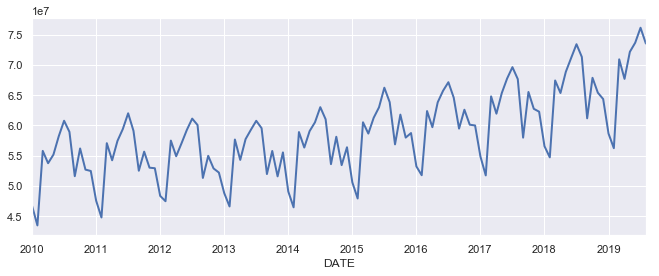

In [15]:
df['PASSENGERS'].plot(linewidth=2);

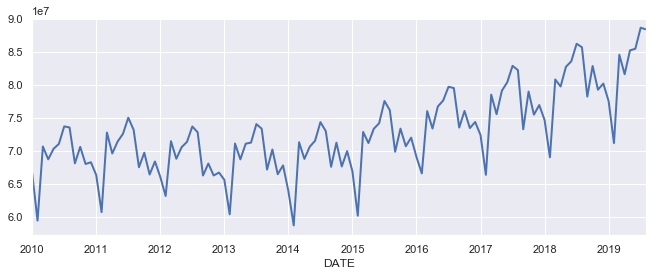

In [17]:
df['SEATS'].plot(linewidth=2);

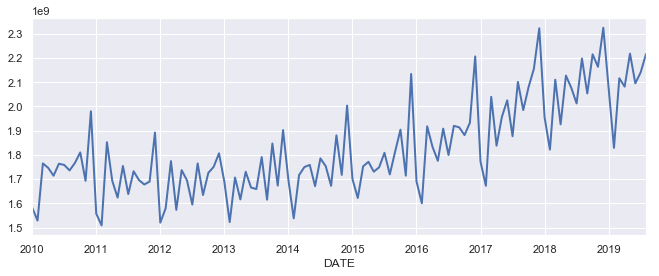

In [18]:
df['FREIGHT'].plot(linewidth=2);

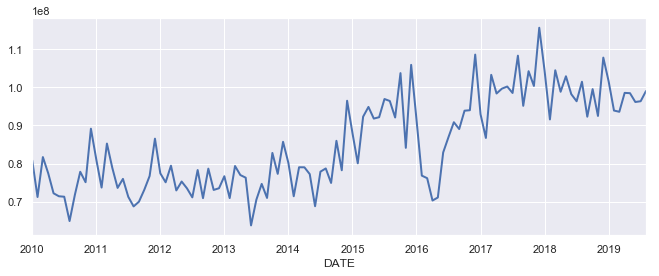

In [19]:
df['MAIL'].plot(linewidth=2);

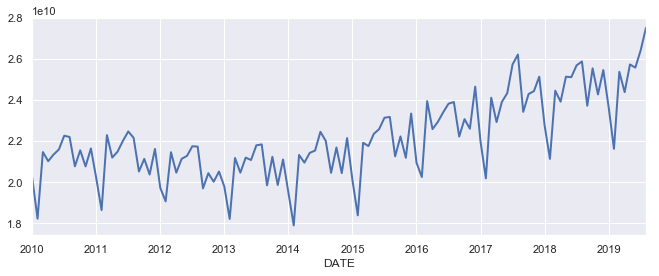

In [20]:
df['PAYLOAD'].plot(linewidth=2);

Text(0.5, 1.0, 'Monthly Passengers (Red) vs. Seats (Blue) in Units of 10 Million')

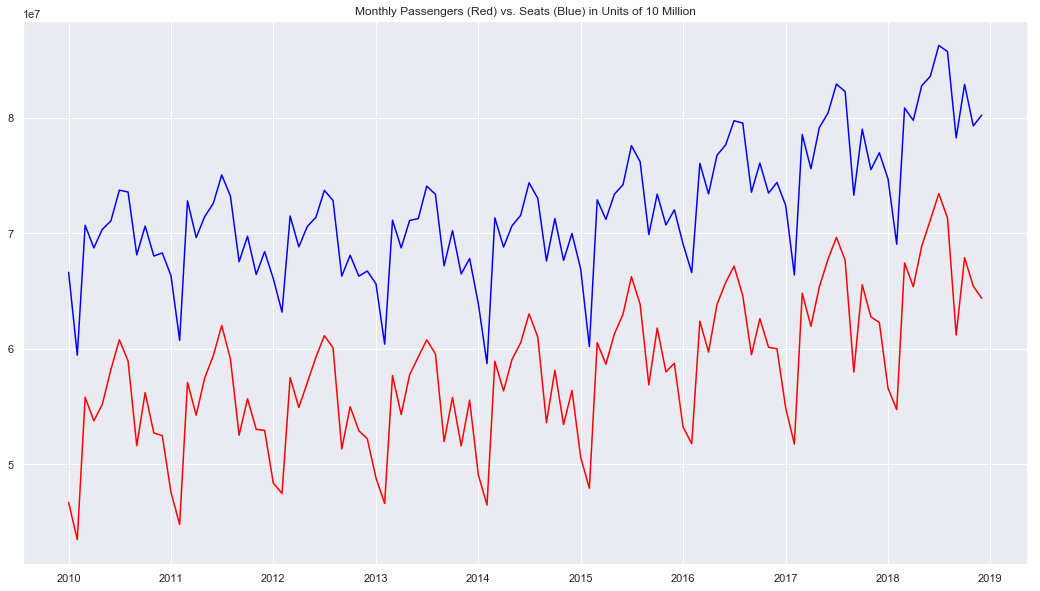

In [266]:
fig, ax = plt.subplots(1, figsize=(18, 10))
ax.plot(df_train.index, df_train['SEATS'], color = "blue")
ax.plot(df_train.index, df_train['PASSENGERS'], color= "red")
ax.set_title("Monthly Passengers (Red) vs. Seats (Blue) in Units of 10 Million")

Text(0.5, 1.0, 'Monthly Pounds of Freight in Units of 1 Billion')

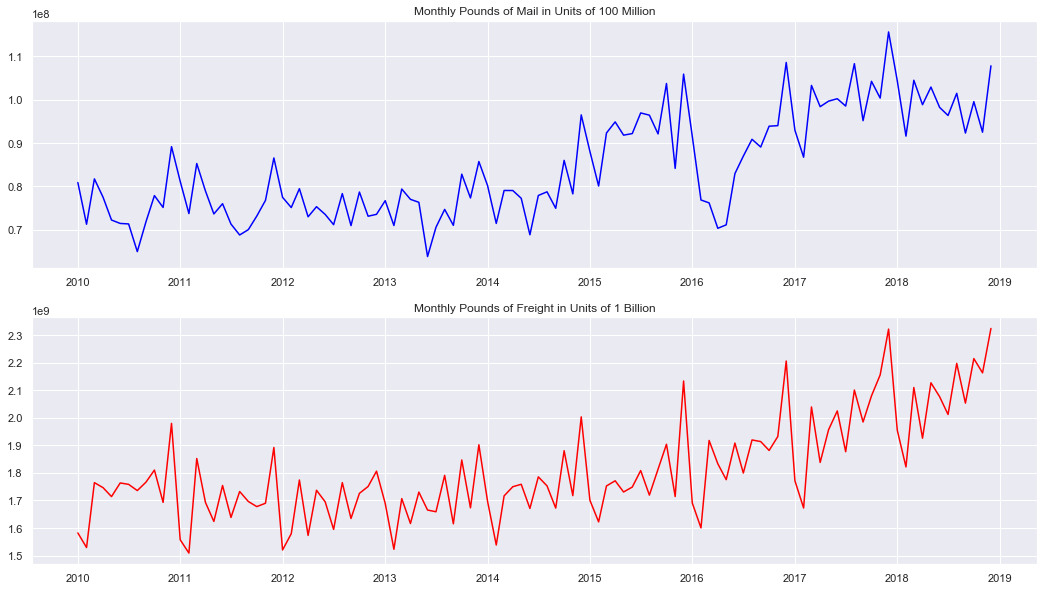

In [273]:
fig, ax = plt.subplots(2, figsize=(18, 10))
ax[0].plot(df_train.index, df_train['MAIL'], color = "blue")
ax[1].plot(df_train.index, df_train['FREIGHT'], color= "red")
ax[0].set_title("Monthly Pounds of Mail in Units of 100 Million")
ax[1].set_title("Monthly Pounds of Freight in Units of 1 Billion")

Text(0.5, 1.0, 'Percentage of Seats Unfilled')

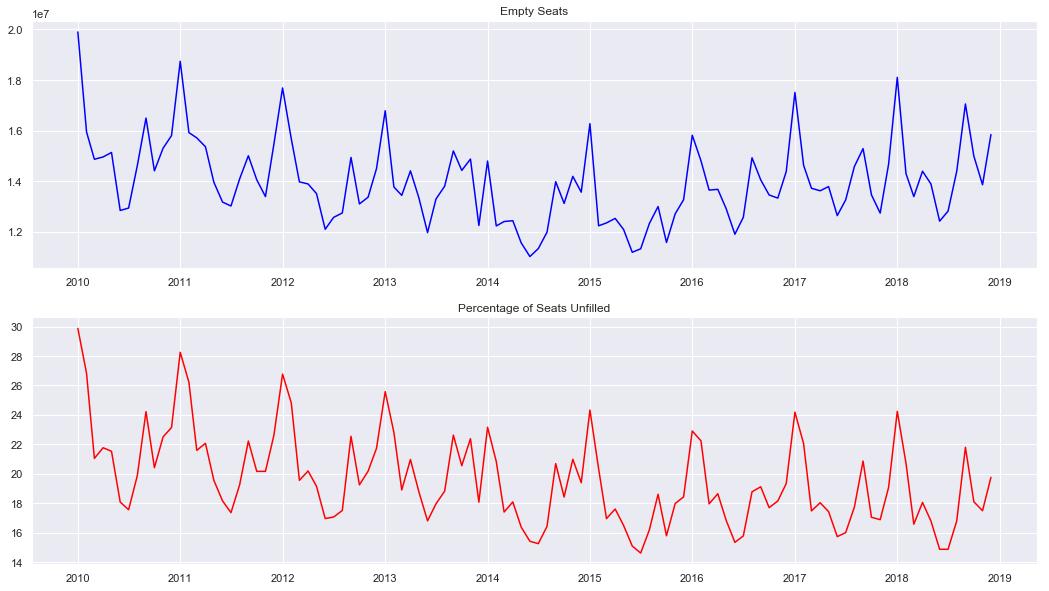

In [276]:
fig, ax = plt.subplots(2, figsize=(18, 10))
ax[0].plot(df_train.index, (df_train.SEATS-df_train.PASSENGERS), color = "blue")
ax[1].plot(df_train.index, (((df_train.SEATS-df_train.PASSENGERS)/df_train.SEATS)*100), color= "red")
ax[0].set_title("Empty Seats")
ax[1].set_title("Percentage of Seats Unfilled")

In [33]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Monthly {}".format(name))

def fit_moving_average_trend(series, window=12):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=12):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)

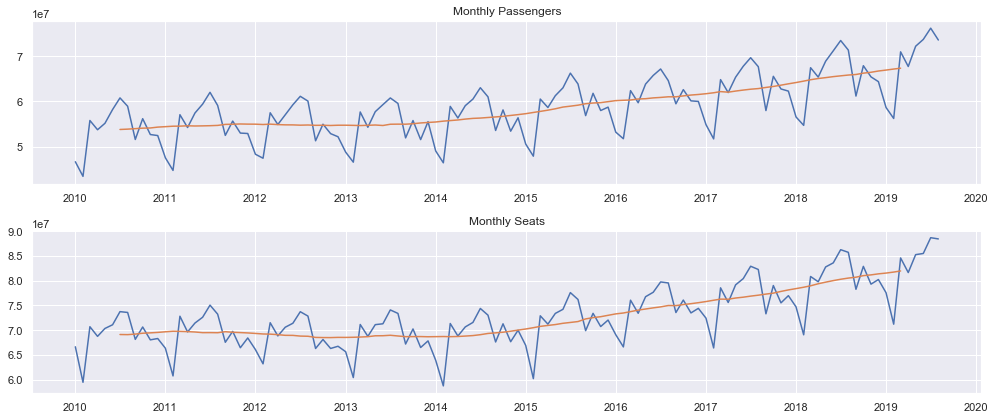

In [34]:
fig, axs = plt.subplots(2, figsize=(14, 6))
plot_moving_average_trend(axs[0], 'Passengers', df['PASSENGERS'])
plot_moving_average_trend(axs[1], 'Seats', df['SEATS'])
plt.tight_layout()

In [35]:
passengers_decomposition = sm.tsa.seasonal_decompose(df['PASSENGERS'])
seats_decomposition = sm.tsa.seasonal_decompose(df['SEATS'])

In [36]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

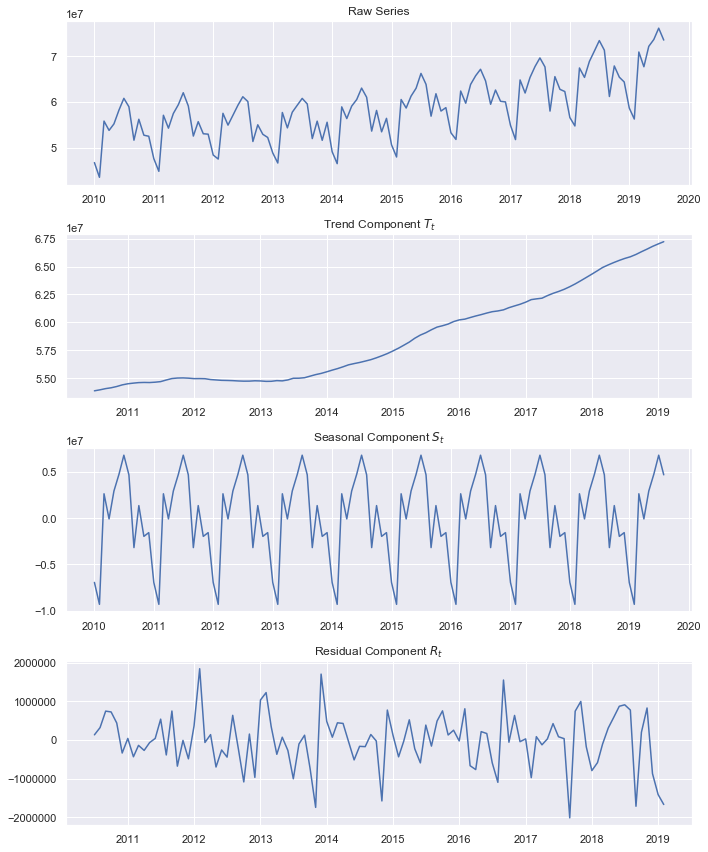

In [271]:
fig, axs = plt.subplots(4, figsize=(10, 12))
plot_seasonal_decomposition(axs, df['PASSENGERS'], passengers_decomposition)
plt.tight_layout()

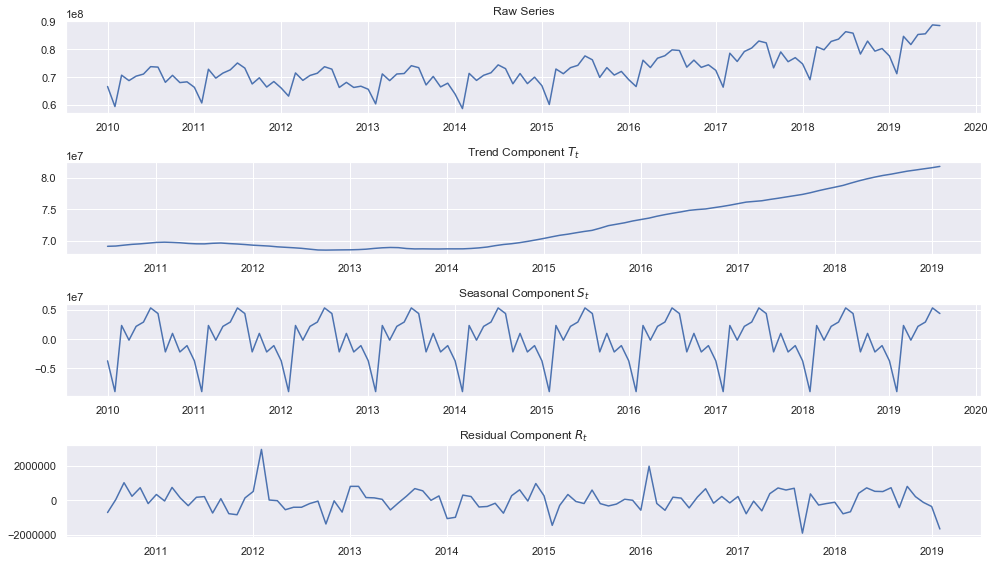

In [38]:
fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, df['SEATS'], seats_decomposition)
plt.tight_layout()

In [39]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

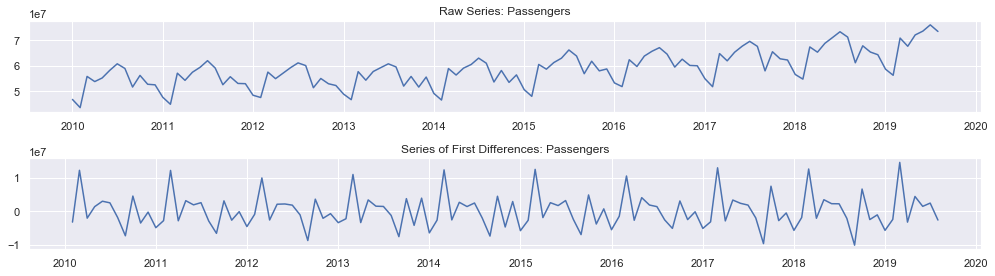

In [40]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, df['PASSENGERS'], 'Passengers')
fig.tight_layout()

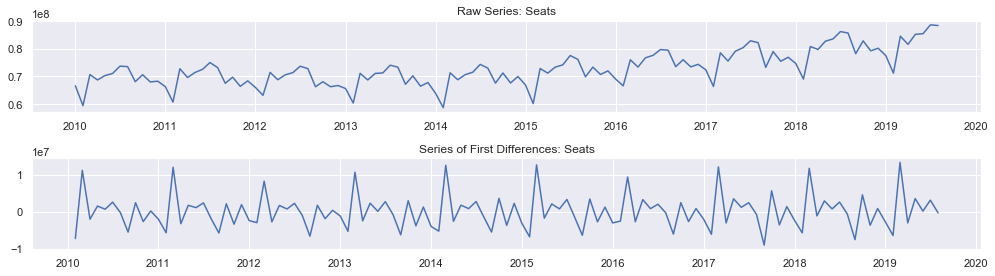

In [41]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, df['SEATS'], 'Seats')
fig.tight_layout()

In [42]:
#testing for stationarity

test = sm.tsa.stattools.adfuller(df['PASSENGERS'])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 1.00


In [45]:
#with differencing

test = sm.tsa.stattools.adfuller(df['PASSENGERS'].diff()[1:])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.38


In [46]:
#double differencing

test = sm.tsa.stattools.adfuller(df['PASSENGERS'].diff()[1:].diff()[1:])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.00


In [47]:
test = sm.tsa.stattools.adfuller(df['SEATS'])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))
test = sm.tsa.stattools.adfuller(df['SEATS'].diff()[1:])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))
test = sm.tsa.stattools.adfuller(df['SEATS'].diff()[1:].diff()[1:])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 1.00
ADF p-value for python series: 0.44
ADF p-value for python series: 0.00


In [48]:
# looking for autocorrelation

def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

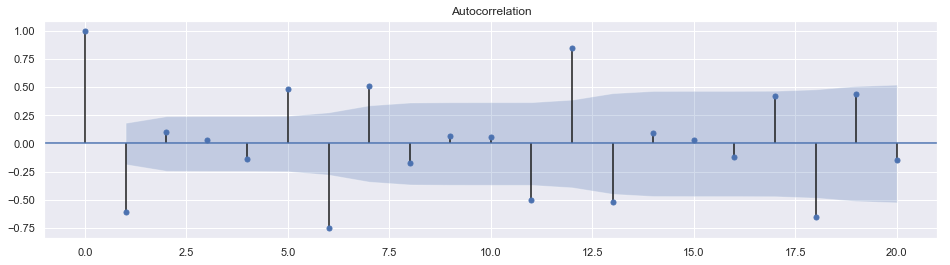

In [88]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(df['PASSENGERS'].diff()[1:].diff()[1:], lags=20, ax=ax)

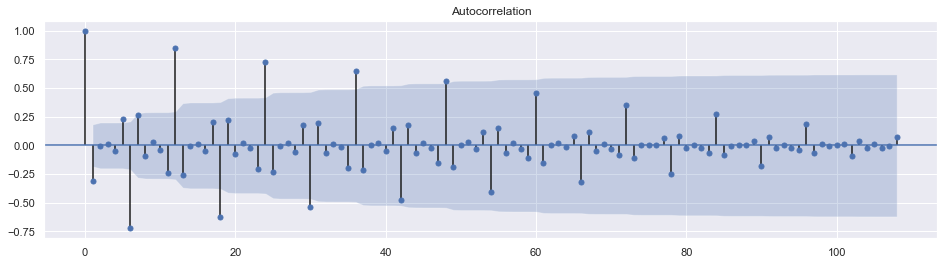

In [69]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_acf(df['PASSENGERS'].diff()[1:], lags=108, ax=ax)

/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


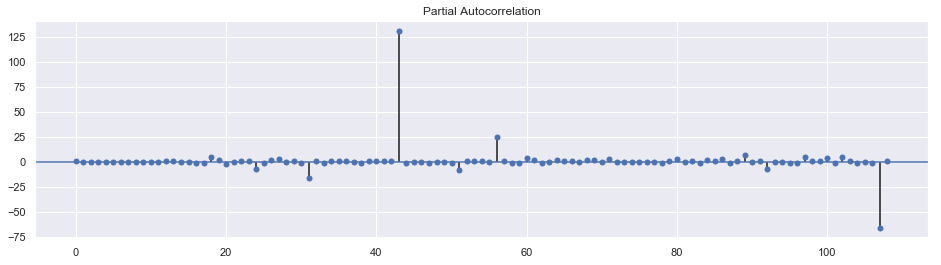

In [272]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(df['PASSENGERS'].diff()[1:], lags=108, ax=ax)

In [136]:
model = SARIMAX(np.log(df['PASSENGERS']), 
                order=(0,1,1), 
                seasonal_order=(0,1,1,12),
                freq=df['PASSENGERS'].index.inferred_freq,
                trend=[0,0,0,0]).fit(method = 'powell')
model.summary()

Optimization terminated successfully.
         Current function value: -2.398896
         Iterations: 3
         Function evaluations: 133


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         PASSENGERS   No. Observations:                  116
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 278.272
Date:                            Fri, 06 Dec 2019   AIC                           -550.544
Time:                                    13:29:15   BIC                           -542.640
Sample:                                01-01-2010   HQIC                          -547.342
                                     - 08-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6848      0.076     -9.070      0.000      -0.833      -0.537
ma.S.L12      -0.6621      0.094     -7.063      0.000      -0.846      -0.478
sigma2         0.0002   3.07e-05      7.986      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       39.07   Jarque-Bera (JB):                13.87
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.52
Prob(H) (two-sided):                  0.47   Kurtosis:                         4.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [203]:
modelA = ARIMA(np.log(df_train['PASSENGERS']), 
                order=(1,1,1),
                freq=df['PASSENGERS'].index.inferred_freq).fit

In [ ]:
modelA.s

In [59]:
model2 = SARIMAX(df.SEATS, order=(0,1,1), seasonal_order=(0,1,1,12), trend='ct').fit(disp = -1)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [60]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              SEATS   No. Observations:                  116
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1596.449
Date:                            Thu, 05 Dec 2019   AIC                           3202.897
Time:                                    10:27:50   BIC                           3216.071
Sample:                                01-01-2010   HQIC                          3208.233
                                     - 08-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -2.18e+04   2.19e+05     -0.099      0.921   -4.52e+05    4.08e+05
drift        974.9110   3178.336      0.307      0.759   -5254.512    7204.334
ma.L1         -0.0401      0.014     -2.848      0.004      -0.068      -0.013
ma.S.L12      -0.0091      0.018     -0.516      0.606      -0.044       0.025
sigma2      1.186e+12      0.096   1.24e+13      0.000    1.19e+12    1.19e+12
===================================================================================
Ljung-Box (Q):                      162.82   Jarque-Bera (JB):                10.43
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.98   Skew:                            -0.09
Prob(H) (two-sided):                  0.95   Kurtosis:                         4.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.04e+28. Standard errors may be unstable.
"""

In [86]:
model = SARIMAX(df.PASSENGERS, order=(0,1,1), seasonal_order=(1,1,1,12), trend='ct').fit(disp = -1)

model.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         PASSENGERS   No. Observations:                  116
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1602.787
Date:                            Fri, 06 Dec 2019   AIC                           3217.573
Time:                                    11:23:15   BIC                           3233.382
Sample:                                01-01-2010   HQIC                          3223.976
                                     - 08-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8645.7063    1.1e+05      0.079      0.937   -2.07e+05    2.24e+05
drift        768.5053   1655.167      0.464      0.642   -2475.562    4012.573
ma.L1         -0.0413      0.010     -4.083      0.000      -0.061      -0.021
ar.S.L12       0.3448      0.209      1.652      0.098      -0.064       0.754
ma.S.L12      -0.3943      0.216     -1.829      0.067      -0.817       0.028
sigma2      8.996e+11      0.009   9.57e+13      0.000       9e+11       9e+11
===================================================================================
Ljung-Box (Q):                      113.07   Jarque-Bera (JB):                33.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             0.23
Prob(H) (two-sided):                  0.29   Kurtosis:                         5.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.42e+30. Standard errors may be unstable.
"""

## Forecasting and Predicting

In [179]:
df_train = df.iloc[:108]
print(df_train.tail())
print(df_train.shape)
df_test = df.iloc[108:]
print(df_test.head())
print(df_test.shape)

                 PAYLOAD  PASSENGERS       SEATS       FREIGHT         MAIL  \
DATE                                                                          
2018-08-01  2.587045e+10  71315947.0  85705734.0  2.198034e+09  101467037.0   
2018-09-01  2.371869e+10  61184158.0  78236175.0  2.053698e+09   92297229.0   
2018-10-01  2.553745e+10  67872165.0  82866863.0  2.215486e+09   99538885.0   
2018-11-01  2.426915e+10  65413173.0  79274692.0  2.163742e+09   92492650.0   
2018-12-01  2.545436e+10  64363721.0  80206321.0  2.325079e+09  107807704.0   

            QUARTER  
DATE                 
2018-08-01    99990  
2018-09-01    93771  
2018-10-01   124632  
2018-11-01   134056  
2018-12-01   131692  
(108, 6)
                 PAYLOAD  PASSENGERS       SEATS       FREIGHT         MAIL  \
DATE                                                                          
2019-01-01  2.365740e+10  58667594.0  77540913.0  2.075799e+09  101571742.0   
2019-02-01  2.162591e+10  56250607.0  71186672

In [218]:
model = SARIMAX(np.log(df_train['PASSENGERS']), 
                order=(0,1,1), 
                seasonal_order=(0,1,1,12),
                freq=df['PASSENGERS'].index.inferred_freq,
                trend=[0,0,0,0]).fit(method = 'powell')
model.summary()

Optimization terminated successfully.
         Current function value: -2.346916
         Iterations: 3
         Function evaluations: 134


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         PASSENGERS   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 253.467
Date:                            Tue, 10 Dec 2019   AIC                           -500.934
Time:                                    11:39:04   BIC                           -493.272
Sample:                                01-01-2010   HQIC                          -497.838
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6859      0.080     -8.535      0.000      -0.843      -0.528
ma.S.L12      -0.6435      0.100     -6.460      0.000      -0.839      -0.448
sigma2         0.0003   3.51e-05      7.457      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       34.46   Jarque-Bera (JB):                10.72
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.50
Prob(H) (two-sided):                  0.94   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [229]:
model2 = SARIMAX(np.log(df_train['PASSENGERS']), 
                order=(1,1,1), 
                seasonal_order=(0,1,1,12),
                freq=df['PASSENGERS'].index.inferred_freq,
                trend=[0,0,0,0]).fit(method = 'powell')
model2.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


Optimization terminated successfully.
         Current function value: -2.352066
         Iterations: 4
         Function evaluations: 235


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         PASSENGERS   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 254.023
Date:                            Tue, 10 Dec 2019   AIC                           -500.046
Time:                                    11:42:40   BIC                           -489.831
Sample:                                01-01-2010   HQIC                          -495.919
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1456      0.148     -0.985      0.325      -0.435       0.144
ma.L1         -0.6152      0.136     -4.538      0.000      -0.881      -0.349
ma.S.L12      -0.6076      0.099     -6.130      0.000      -0.802      -0.413
sigma2         0.0003   3.34e-05      7.772      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       33.02   Jarque-Bera (JB):                10.08
Prob(Q):                              0.77   Prob(JB):                         0.01
Heteroskedasticity (H):               0.99   Skew:                             0.47
Prob(H) (two-sided):                  0.98   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [230]:
model3 = SARIMAX(np.log(df_train['PASSENGERS']), 
                order=(1,1,1), 
                seasonal_order=(1,1,1,12),
                freq=df['PASSENGERS'].index.inferred_freq,
                trend=[0,0,0,0]).fit(method = 'powell')
model3.summary()

Optimization terminated successfully.
         Current function value: -2.384869
         Iterations: 5
         Function evaluations: 339


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         PASSENGERS   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 257.566
Date:                            Tue, 10 Dec 2019   AIC                           -505.132
Time:                                    11:42:43   BIC                           -492.362
Sample:                                01-01-2010   HQIC                          -499.972
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1787      0.133     -1.347      0.178      -0.439       0.081
ma.L1         -0.6180      0.132     -4.682      0.000      -0.877      -0.359
ar.S.L12       0.3813      0.242      1.574      0.116      -0.094       0.856
ma.S.L12      -0.9820      2.750     -0.357      0.721      -6.371       4.407
sigma2         0.0002      0.001      0.389      0.697      -0.001       0.001
===================================================================================
Ljung-Box (Q):                       31.21   Jarque-Bera (JB):                13.60
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.36
Prob(H) (two-sided):                  0.98   Kurtosis:                         4.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [226]:
yhat = np.exp(model.forecast(8))

In [227]:
yhat

2019-01-01    5.898728e+07
2019-02-01    5.650282e+07
2019-03-01    7.000157e+07
2019-04-01    6.731145e+07
2019-05-01    7.097502e+07
2019-06-01    7.330838e+07
2019-07-01    7.565213e+07
2019-08-01    7.333632e+07
Freq: MS, dtype: float64

In [221]:
df_test.head(8)

,PAYLOAD,PASSENGERS,SEATS,FREIGHT,MAIL,QUARTER
DATE,,,,,,
2019-01-01,2.365740e+10,58667594.0,77540913.0,2.075799e+09,101571742.0,32260
2019-02-01,2.162591e+10,56250607.0,71186672.0,1.829085e+09,93918241.0,30745
2019-03-01,2.536898e+10,70925783.0,84570878.0,2.116534e+09,93590305.0,32073
2019-04-01,2.437992e+10,67696442.0,81618704.0,2.081885e+09,98549490.0,62592
2019-05-01,2.572605e+10,72160603.0,85236869.0,2.218373e+09,98471036.0,63450
2019-06-01,2.557159e+10,73661690.0,85472234.0,2.095641e+09,96158281.0,67876
2019-07-01,2.641174e+10,76138578.0,88660530.0,2.140761e+09,96358997.0,98481
2019-08-01,2.750959e+10,73532658.0,88414706.0,2.216546e+09,99026718.0,101283


In [184]:
np.log(61184158)

17.929398857764355

Text(0.5, 1.0, 'Forecasts for Monthly Air Passengers (Red) vs. Actual (Blue)')

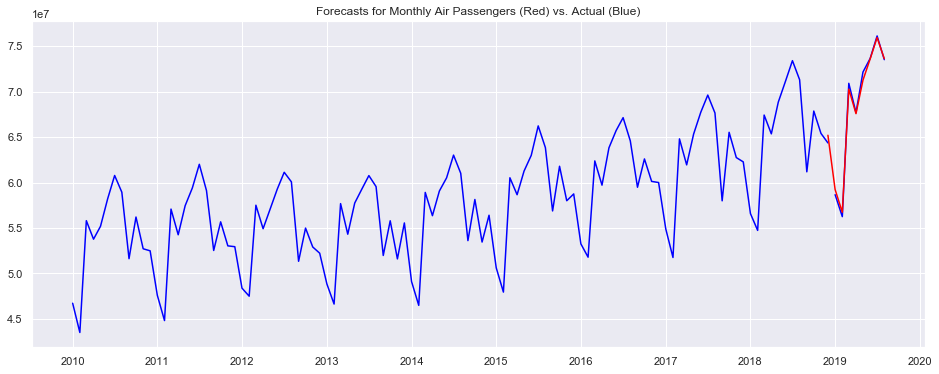

In [254]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(df_train.index, df_train['PASSENGERS'], color = "blue")

ax.plot(df_test.index, df_test['PASSENGERS'], color = "blue")

preds = model.predict('2018-12-01', '2019-08-01', 
                   dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, np.exp(preds), color= "red")
ax.set_title("Forecasts for Monthly Air Passengers (Red) vs. Actual (Blue)")

In [164]:
model2 = SARIMAX(np.log(df_train['SEATS']), 
                order=(0,1,1), 
                seasonal_order=(0,1,1,12),
                freq=df['SEATS'].index.inferred_freq,
                trend=[0,0,0,0]).fit(method = 'powell')
model2.summary()

Optimization terminated successfully.
         Current function value: -2.486487
         Iterations: 4
         Function evaluations: 216


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              SEATS   No. Observations:                  104
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 258.595
Date:                            Fri, 06 Dec 2019   AIC                           -511.189
Time:                                    16:21:13   BIC                           -503.657
Sample:                                01-01-2010   HQIC                          -508.150
                                     - 08-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5402      0.086     -6.284      0.000      -0.709      -0.372
ma.S.L12      -0.8522      0.269     -3.163      0.002      -1.380      -0.324
sigma2         0.0002   4.27e-05      3.948      0.000    8.49e-05       0.000
===================================================================================
Ljung-Box (Q):                       33.64   Jarque-Bera (JB):                23.18
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.31
Prob(H) (two-sided):                  0.18   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


Text(0.5, 1.0, 'Forecasts for Monthly Available Seats (Red) vs. Actual (Blue)')

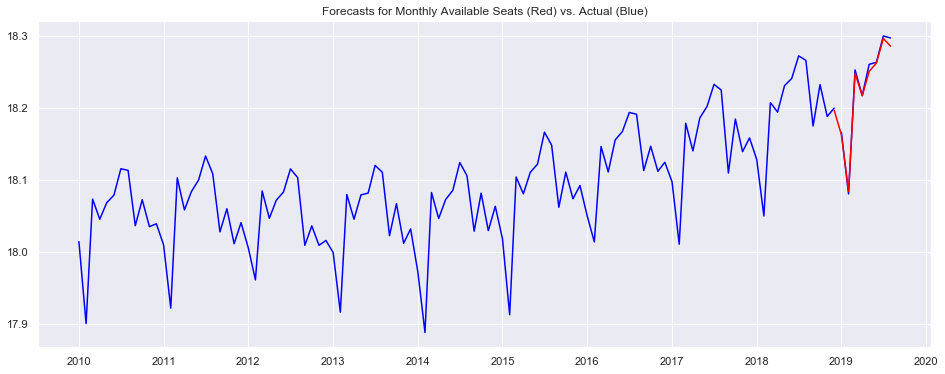

In [188]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(df_train.index, np.log(df_train['SEATS']), color = "blue")

ax.plot(df_test.index, np.log(df_test['SEATS']), color = "blue")

preds = model2.predict('2018-12-01', '2019-08-01', 
                   dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, preds, color= "red")
ax.set_title("Forecasts for Monthly Available Seats (Red) vs. Actual (Blue)")

In [175]:
model3 = SARIMAX(np.log(df_train['FREIGHT']), 
                order=(0,1,0), 
                seasonal_order=(0,1,0,12)).fit()
model3.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            FREIGHT   No. Observations:                  104
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 123.425
Date:                            Fri, 06 Dec 2019   AIC                           -244.850
Time:                                    16:24:34   BIC                           -242.340
Sample:                                01-01-2010   HQIC                          -243.837
                                     - 08-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0039      0.001      5.754      0.000       0.003       0.005
===================================================================================
Ljung-Box (Q):                      357.78   Jarque-Bera (JB):                 2.11
Prob(Q):                              0.00   Prob(JB):                         0.35
Heteroskedasticity (H):               0.77   Skew:                             0.25
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


Text(0.5, 1.0, 'Forecasts for Monthly Freight (Red) vs. Actual (Blue)')

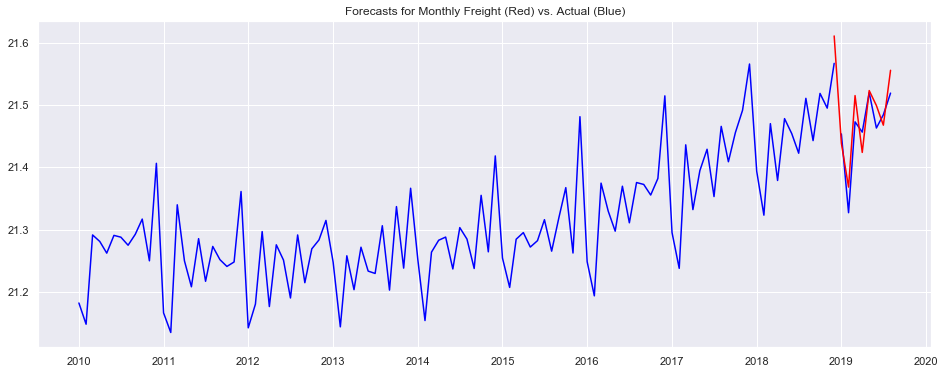

In [189]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(df_train.index, np.log(df_train['FREIGHT']), color = "blue")

ax.plot(df_test.index, np.log(df_test['FREIGHT']), color = "blue")

preds = model3.predict('2018-12-01', '2019-08-01', 
                   dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, preds, color= "red")
ax.set_title("Forecasts for Monthly Freight (Red) vs. Actual (Blue)")

In [177]:
model4 = SARIMAX(np.log(df_train['MAIL']), 
                order=(0,1,1), 
                seasonal_order=(0,1,1,12),
                freq=df['MAIL'].index.inferred_freq,
                trend=[0,0,0,0]).fit(method = 'powell')
model4.summary()

Optimization terminated successfully.
         Current function value: -1.124543
         Iterations: 3
         Function evaluations: 142


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               MAIL   No. Observations:                  104
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 116.952
Date:                            Fri, 06 Dec 2019   AIC                           -227.905
Time:                                    16:31:05   BIC                           -220.372
Sample:                                01-01-2010   HQIC                          -224.866
                                     - 08-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3229      0.085     -3.812      0.000      -0.489      -0.157
ma.S.L12      -0.7492      0.134     -5.575      0.000      -1.013      -0.486
sigma2         0.0040      0.001      7.482      0.000       0.003       0.005
===================================================================================
Ljung-Box (Q):                      109.60   Jarque-Bera (JB):                 3.69
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               1.06   Skew:                            -0.13
Prob(H) (two-sided):                  0.87   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


Text(0.5, 1.0, 'Forecasts for Monthly Mail (Red) vs. Actual (Blue)')

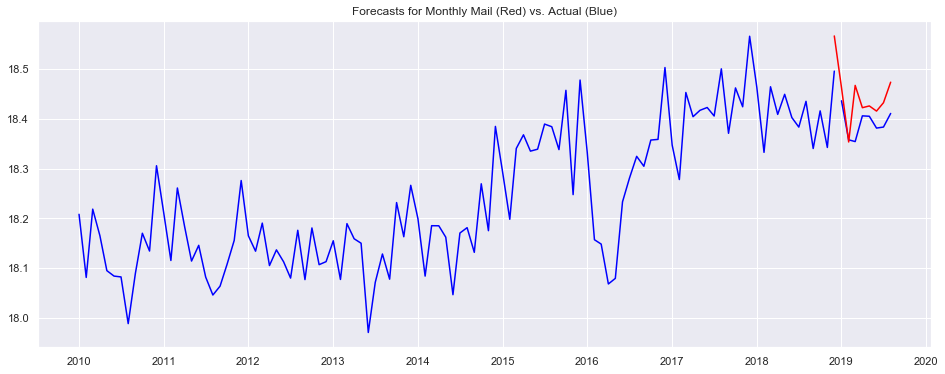

In [190]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(df_train.index, np.log(df_train['MAIL']), color = "blue")

ax.plot(df_test.index, np.log(df_test['MAIL']), color = "blue")

preds = model4.predict('2018-12-01', '2019-08-01', 
                   dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, preds, color= "red")
ax.set_title("Forecasts for Monthly Mail (Red) vs. Actual (Blue)")

In [191]:
df['EXCESS_SEATS'] = df.SEATS - df.PASSENGERS

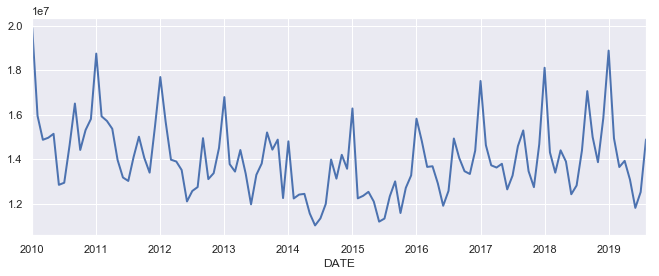

In [192]:
df['EXCESS_SEATS'].plot(linewidth = 2)

In [216]:
def mean_absolute_percentage_error(y_true, y_pred):
     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [228]:
mean_absolute_percentage_error(df_test.PASSENGERS, yhat)

0.7366985512450689

In [231]:
yhat2 = np.exp(model2.forecast(8))
yhat3 = np.exp(model3.forecast(8))

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [232]:
mean_absolute_percentage_error(df_test.PASSENGERS, yhat2)

0.7127267682208935

In [233]:
mean_absolute_percentage_error(df_test.PASSENGERS, yhat3)

0.5828390787492889

Text(0.5, 1.0, 'Forecasts for Monthly Air Passengers (Red) vs. Actual (Blue), Model with AR Component')

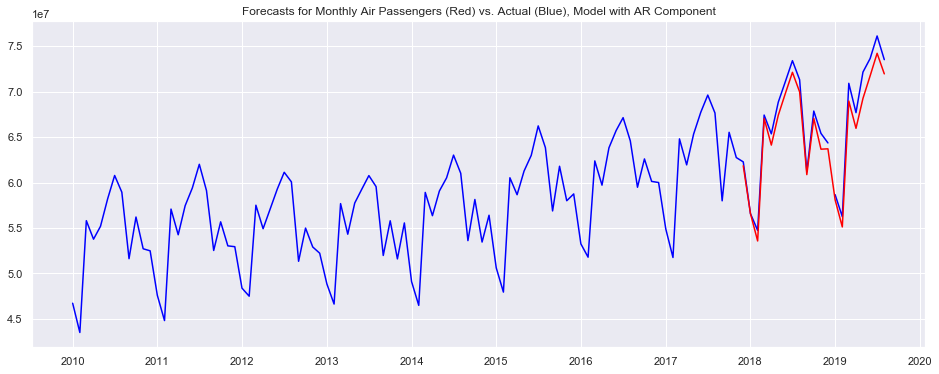

In [252]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(df_train.index, df_train['PASSENGERS'], color = "blue")

ax.plot(df_test.index, df_test['PASSENGERS'], color = "blue")

preds = model3.predict('2017-12-01', '2019-08-01', 
                   dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, np.exp(preds), color= "red")
ax.set_title("Forecasts for Monthly Air Passengers (Red) vs. Actual (Blue), Model with AR Component")

In [238]:
residuals3 = df_test.PASSENGERS - yhat3

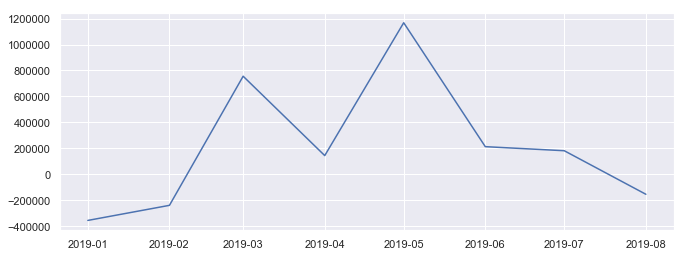

In [240]:
plt.plot(residuals3)

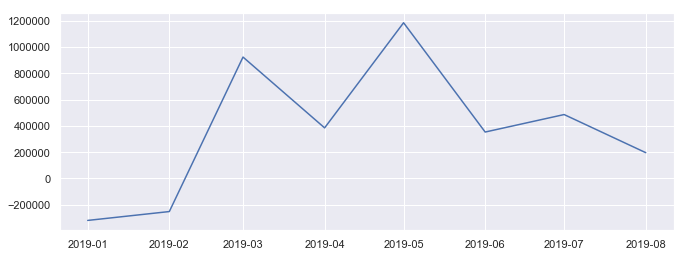

In [241]:
residuals = df_test.PASSENGERS - yhat
plt.plot(residuals)

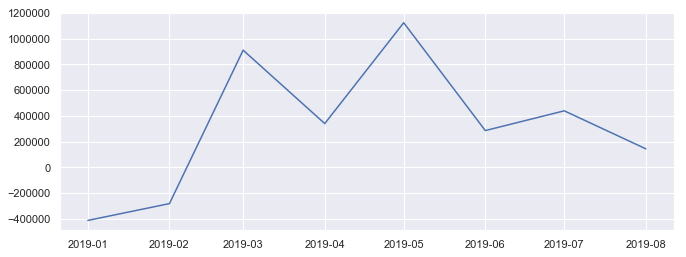

In [242]:
residuals2 = df_test.PASSENGERS - yhat2
plt.plot(residuals2)

Text(0.5, 1.0, 'Forecast for Air Passengers')

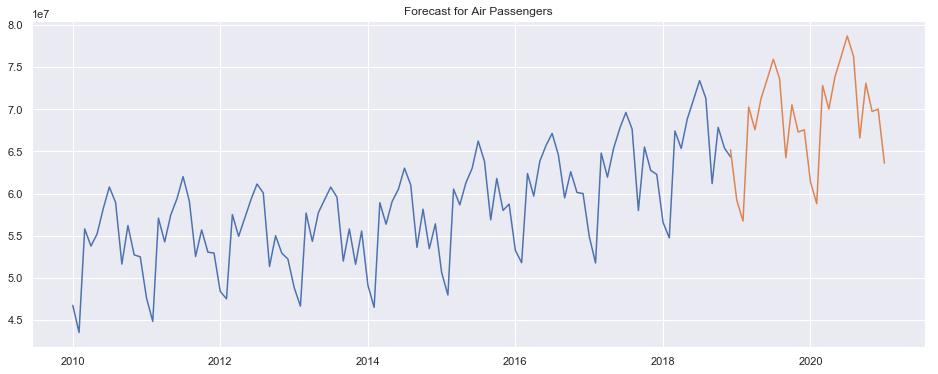

In [250]:
fig, ax = plt.subplots(1, figsize=(16, 6))
ax.plot(df_train.index, df_train.PASSENGERS)

preds = model.predict('2018-12-01', '2021', 
                   dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, np.exp(preds))
ax.set_title("Forecast for Air Passengers")

In [278]:
df_train2 = df.iloc[72:108]
print(df_train2.head())
print(df_train2.shape)

                 PAYLOAD  PASSENGERS       SEATS       FREIGHT        MAIL  \
DATE                                                                         
2016-01-01  2.095267e+10  53250230.0  69067999.0  1.690818e+09  91545597.0   
2016-02-01  2.025451e+10  51786086.0  66593065.0  1.600357e+09  76848588.0   
2016-03-01  2.394425e+10  62383561.0  76033928.0  1.918059e+09  76178126.0   
2016-04-01  2.258120e+10  59715139.0  73394647.0  1.833499e+09  70318090.0   
2016-05-01  2.293399e+10  63827068.0  76736777.0  1.775617e+09  71110038.0   

            QUARTER  EXCESS_SEATS  
DATE                               
2016-01-01    32126    15817769.0  
2016-02-01    30742    14806979.0  
2016-03-01    31414    13650367.0  
2016-04-01    63092    13679508.0  
2016-05-01    60664    12909709.0  
(36, 7)


In [283]:
model_short = SARIMAX(np.log(df_train2['PASSENGERS']), 
                order=(1,1,1), 
                seasonal_order=(1,1,1,12), enforce_invertibility=False).fit(method = 'powell')
model_short.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ValueError: maxlag should be < nobs